In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
import time
import pickle as pkl

In [2]:
from simulation_tools_2DOF import Servo_2DOF, simulation_init_2dof

In [3]:
class NeuralNetwork:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Dense(4, input_shape=(4,), activation='relu', name="intermediate_layer"))
        self.model.add(Dense(3))
        
        self.stored_weights = None
        self.stored_weight_layer = None
        self.update_intermediate_model()

    
    def predict(self, e, y_prev):
        input_vec = np.array([np.concatenate(([e, y_prev], [self.prev_intermediate_output[0]], 
                                              [self.prev_intermediate_output[3]]))])
        output = self.model.predict(input_vec, batch_size=1)
        
        self.prev_intermediate_output = self.intermediate_layer_model.predict(input_vec, batch_size=1).flatten()

        return output
        
    def copy_weights(self, source_model):
        for i in range(len(self.model.layers)):
            self.model.layers[i].set_weights(source_model.layers[i].get_weights())

            
    def temp_weight_change(self, layer_num, weight_num, index, delta):
        temp_weights = self.model.layers[layer_num].get_weights()
        self.stored_weights = self.model.layers[layer_num].get_weights()
        
        temp_weights[weight_num][index] += delta
        self.model.layers[layer_num].set_weights(temp_weights)

        self.stored_weight_layer = layer_num
    
    def temp_weight_restore(self):
        self.model.layers[self.stored_weight_layer].set_weights(self.stored_weights)

    
    def adjust_weights(self, weight_adjustment_list):
        current_w = 0        
        layers = self.model.layers
        for layer_num, layer in enumerate(layers):
            temp_weights = []
            for weight in layer.get_weights():
                for index in np.ndindex(weight.shape):
                    weight[index] += weight_adjustment_list[current_w]
                    current_w += 1
                temp_weights.append(weight)
                
            self.model.layers[layer_num].set_weights(temp_weights)
        
    def update_intermediate_model(self):
        self.prev_intermediate_output = np.array([0, 0, 0, 0])
        self.intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer("intermediate_layer").output)


In [12]:
class PIDTuner_2DOF:
    def __init__(self):
        self.servos = Servo_2DOF()
        self.nn_rot = NeuralNetwork()
        self.nn_flex = NeuralNetwork()

        self.stored_nn_rot = None
        self.stored_nn_flex = None
    
    def simulate_2dof(self, T, y0, r, d, use_nn=True):
        self.servos.reset() #Reset neural model and PID conrollers
        self.nn_rot.update_intermediate_model()
        self.nn_flex.update_intermediate_model()
        
        self.servos.pid_rot.update_gains(0.32, 0.06, 0.00879)
        self.servos.pid_flex.update_gains(0.29, 0.42, 0.00800)

        y = np.zeros(shape=(len(T), 2))
        angle = np.zeros(shape=(len(T), 2))
        
        y[0] = y0
        
        angle[0] = y[0] * 180/math.pi + 180 + d[0]
                
        gains_rot = np.zeros(shape=(len(T), 3))
        gains_flex  = np.zeros(shape=(len(T), 3))

        for i in range(1, len(T)):
            
            e = np.zeros(2)
            e = r[i] - angle[i-1]
            
            if use_nn:
                e_norm = e/180
                y_prev_norm = (y[i-1]-(-math.pi))/(math.pi-(-math.pi))

                gains_rot[i] = np.absolute(self.nn_rot.predict(e_norm[0], y_prev_norm[0]).flatten())
                gains_flex[i] = np.absolute(self.nn_rot.predict(e_norm[1], y_prev_norm[1]).flatten())
                
                for gain in (gains_rot[i] + gains_flex[i]):
                    assert not math.isnan(gain), "NaN Neural Network output"
                    
                self.servos.pid_rot.update_gains(gains_rot[i, 0], gains_rot[i, 1], gains_rot[i, 2])
                self.servos.pid_flex.update_gains(gains_flex[i, 0], gains_flex[i, 1], gains_flex[i, 2])

            
            y[i], angle[i] = self.servos.simulate_step_model_free(y[i-1], angle[i-1], T[i], r[i], d[i])

        return angle, (gains_rot, gains_flex)
    

    def compute_jacobian_2dof(self, T, y0, r, d):
        jacobian_rot = np.empty((len(T), self.nn_rot.model.count_params()))
        jacobian_flex = np.empty((len(T), self.nn_rot.model.count_params()))

        y1, _ = self.simulate_2dof(T, y0, r, d)
        
        jacobian_rot = self.iter_weights(T, y0, r, d, y1, jacobian_rot, 0)
        jacobian_flex = self.iter_weights(T, y0, r, d, y1, jacobian_flex, 1)
            
        return jacobian_rot, jacobian_flex, y1
    
    def iter_weights(self, T, y0, r, d, y1, jacobian, servo):
        current_w = 0

        if servo == 0:
            layers = self.nn_rot.model.layers
        else: #if servo == 1
            layers = self.nn_flex.model.layers
        for layer_num, layer in enumerate(layers):
            for weight_num, weight in enumerate(layer.get_weights()):
                for index in np.ndindex(weight.shape):
                    wij = weight[index]
                    epsilon = max(1, abs(wij)) * math.sqrt(sys.float_info.epsilon)        
                    
                    if servo == 0:
                        self.nn_rot.temp_weight_change(layer_num, weight_num, index, epsilon)
                    else: #if servo == 1
                        self.nn_flex.temp_weight_change(layer_num, weight_num, index, epsilon)
        
                    y2, _ = self.simulate_2dof(T, y0, r, d)
                    if servo == 0:
                        self.nn_rot.temp_weight_restore()
                    else: #if servo == 1
                        self.nn_flex.temp_weight_restore()
                    
                    for t in range(len(T)):
                        jacobian[t, current_w] = (y1[t, servo] - y2[t, servo])/epsilon
                    current_w += 1
        return jacobian
                    
    def store_nn(self):
        self.stored_nn_rot = NeuralNetwork()
        self.stored_nn_rot.copy_weights(self.nn_rot.model)
        self.stored_nn_flex = NeuralNetwork()
        self.stored_nn_flex.copy_weights(self.nn_flex.model)
    def restore_nn(self):
        self.nn_rot = self.stored_nn_rot
        self.nn_flex = self.stored_nn_flex
        

In [5]:
def compute_adjustment(J, error, damping_factor):
    #Compute adjustment amount
    A = np.matmul(np.transpose(J), J) + damping_factor * np.identity(J.shape[1])
    B = np.matmul(np.transpose(J), (error))
    #https://scicomp.stackexchange.com/questions/14200/levenberg-marquardt-how-to-calculate-the-jacobian-with-fixed-parameters
    return np.matmul(np.linalg.inv(A), B) 

Simulation time steps: 500


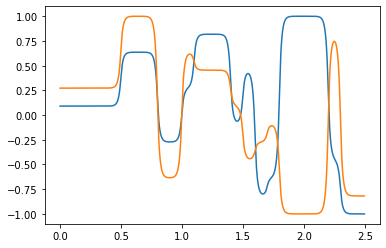

Samples: 250
Starting trial 0
Done iteration: 0 | sq_error: 17.420571302839672 | adj_sq_error: 17.02586469887623


c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


Done iteration: 1 | sq_error: 17.02586469887623 | adj_sq_error: 17.450353738834668
Done iteration: 2 | sq_error: 17.02586469887623 | adj_sq_error: 17.450353738834668
Trial finished, diff: 0.0


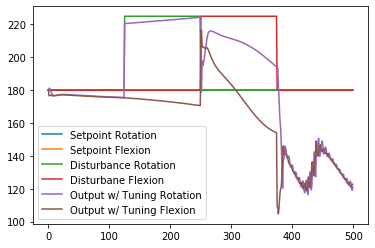

Old best: None | New best: 17.02586469887623
[array([[ 0.6833696 , -0.08813781,  0.08138025, -0.02662307],
       [ 0.24484971, -0.40596965, -0.82053924, -0.3833111 ],
       [-0.4602837 ,  0.75688845, -0.8546318 , -0.4943709 ],
       [-0.41436973,  0.8199592 , -0.8348819 , -0.46897617]],
      dtype=float32), array([0.00047402, 0.        , 0.        , 0.        ], dtype=float32)]
[array([[ 0.03854917,  0.81736267, -0.6505375 ],
       [-0.41973585,  0.59357345,  0.25818622],
       [-0.4792167 , -0.63178957, -0.40122586],
       [-0.8113689 , -0.46646473, -0.7930708 ]], dtype=float32), array([ 0.00285535, -0.00147559,  0.00020642], dtype=float32)]
[array([[ 0.28213638, -0.1627692 , -0.7217598 ,  0.6069692 ],
       [-0.47718856, -0.38668802,  0.3808282 ,  0.82009965],
       [-0.6125036 , -0.5309478 ,  0.8132017 , -0.5217309 ],
       [ 0.00141376,  0.3836035 , -0.26828098, -0.24369806]],
      dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
[array([[ 0.2016201 ,  0.09373128,

KeyboardInterrupt: 

In [16]:
T, r, d, d_test, y0 = simulation_init_2dof(0.005, 2.5, aprbs_hold=100, aprbs_amp=2)
simulation_length = len(T)
print("Simulation time steps:",simulation_length)
plt.plot(T, d)
plt.show()


sample_increase = 250
max_trials = simulation_length//sample_increase
samples = sample_increase

# samples = simulation_length

best_sq_error = None
trial = 0
pid_tuner = PIDTuner_2DOF()

lstm_weights = pkl.load(open('Model Free Training/lstm_weights_2dof.pkl', 'rb'))
pid_tuner.servos.neural_model_from_weights(lstm_weights)


while(trial < max_trials):
    try:
        pid_tuner.nn_rot = NeuralNetwork()
        pid_tuner.nn_flex = NeuralNetwork()

        prev_adj_sq_error = 0
        iters = 0
        damping_factor = 10
        print("Samples:", samples)
        print("Starting trial", trial)
        trial_finished = False
        while(not trial_finished):

            #Compute jacobian
            J_rot, J_flex, y = pid_tuner.compute_jacobian_2dof(T[:samples], y0, r[:samples], d[:samples]) 
            #Get error of output without weight change
            error = y - r[:samples] 

            try_solve_levenberg = True
            while(try_solve_levenberg):
                adjustment_rot = compute_adjustment(J_rot, error[:, 0], damping_factor)
                adjustment_flex = compute_adjustment(J_flex, error[:, 1], damping_factor)

                #Store a copy of the current neural network before adjusting the weights
                pid_tuner.store_nn()
                pid_tuner.nn_rot.adjust_weights(adjustment_rot)
                pid_tuner.nn_flex.adjust_weights(adjustment_flex)

                #Simulate with the adjusted weights
                y_adj, _ = pid_tuner.simulate_2dof(T[:samples], y0, r[:samples], d[:samples]) 

                #Calculate squared error of output without weight change
                sq_error = (np.sum(np.square(error[:, 0])) + np.sum(np.square(error[:, 1])))/(2*samples)

                #Calculate squared error of output with weight change
                adj_sq_error = (np.sum(np.square(y_adj[:, 0] - r[:samples, 0])) + np.sum(np.square(y_adj[:, 1] - r[:samples, 1])))/(2*samples)

                if adj_sq_error < sq_error:
                    #If squared error with weight change is better, half damping factor and keep new weights
                    damping_factor = damping_factor/2 
                    try_solve_levenberg = False #New sq error is less than the old one
                else:
                    #If not better, double damping factor and restore old weights (from our stored copy)
                    damping_factor = 2 * damping_factor
                    pid_tuner.restore_nn()

            #     print(adjustment)
            
                print("Done iteration:", iters, "| sq_error:", sq_error, "| adj_sq_error:", adj_sq_error)
                
                if (abs(1-adj_sq_error/prev_adj_sq_error) < 0.001):
                    print("Trial finished, diff:", abs(1-adj_sq_error/prev_adj_sq_error))
                    trial_finished = True
                    try_solve_levenberg = False
                    
                prev_adj_sq_error = adj_sq_error
                iters += 1

        y, _ = pid_tuner.simulate_2dof(T, y0, r, d_test) 
        plt.plot(r)
        plt.plot(d_test + 180)
        plt.plot(y)
        plt.legend(['Setpoint Rotation', 'Setpoint Flexion',
                    'Disturbance Rotation', 'Disturbane Flexion',
                    'Output w/ Tuning Rotation', 'Output w/ Tuning Flexion'])
        plt.show()
        if (best_sq_error is None or sq_error < best_sq_error) and sq_error != 0:
            print("Old best:", best_sq_error, "| New best:", sq_error)
            best_sq_error = sq_error
            best_models = [NeuralNetwork(), NeuralNetwork()]
            best_models[0].copy_weights(pid_tuner.nn_rot.model)
            best_models[1].copy_weights(pid_tuner.nn_flex.model)
            for best_model in best_models:
                for layer in best_model.model.layers:
                    print(layer.get_weights())

        samples += sample_increase
        trial += 1
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            damping_factor = 2 * damping_factor

            print("Unable to invert A")
        else:
            raise
    except AssertionError:
        print("NaN neural network output")



In [12]:
#To copy paste into C#
weight_names = ['w1', 'b1', 'w2', 'b2']
w_index = 0
for layer in best_model.model.layers:
    for w in layer.get_weights():
        print("Matrix<double>", weight_names[w_index], "= M.DenseOfArray(new double[,]{", end='')
        for i, row in enumerate(w):
            if type(row) is not np.float32:
                print("{", end='')
                for j in row:
                    print(str(j) + ",", end='')
                print("},", end='')
            else:
                if i == 0:
                    print("{",end='')
                print(str(row) + ",", end='')
                if i == len(w) - 1:
                    print("}",end='')
        print("});")
        w_index += 1

Matrix<double> w1 = M.DenseOfArray(new double[,]{{-0.7119679,0.42913443,0.47652644,-0.7014039,},{0.2718367,-0.14591663,-0.06690835,0.21440148,},{0.4139611,0.17392927,0.04323417,-0.5855943,},{0.85303384,-0.57226396,-0.16563505,0.21442007,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.0074934964,0.006738262,-0.012452071,-0.0008383206,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{-0.81974745,0.40895438,0.46149206,},{0.2760327,-0.84172624,0.50886106,},{-0.6494305,0.2374618,0.16392128,},{0.24123633,-0.80385095,0.27239084,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.0028225207,0.0062326863,-0.00015154688,}});


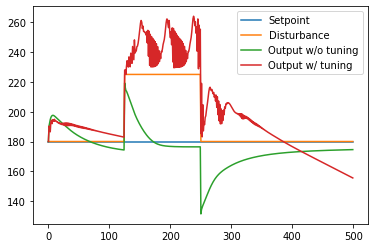

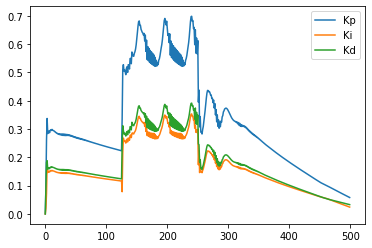

In [13]:
#test

rot_tuner.nn.copy_weights(best_model.model)
y, gains = rot_tuner.simulate(T, y0, r, d_test) 
y_test, _ = rot_tuner.simulate(T, y0, r, d_test, use_nn=False) 
plt.plot(r)
plt.plot(d_test + 180)
plt.plot(y_test)
plt.plot(y)
plt.legend(['Setpoint', 'Disturbance', 'Output w/o tuning', 'Output w/ tuning'])
plt.show()
plt.plot(gains[0])
plt.plot(gains[1])
plt.plot(gains[2])
plt.legend(['Kp', 'Ki', 'Kd'])
plt.show()